# Pattern Matching 4 - Video, Matching & Tracking

**Objectives**

* Analyze video sequences
* Match objects between frames for tracking

**The goal is to track fishes through the different frames.**

## Video import

[Download](https://my.pcloud.com/publink/show?code=XZpIUMkZQX7lwSh8BPpO5vF6UWC6xSXgVLRy) the images from the video sequence, and the supervised segmentation ground truth: 

(Reference: http://groups.inf.ed.ac.uk/f4k/PAPERS/VIGTA2012.pdf)

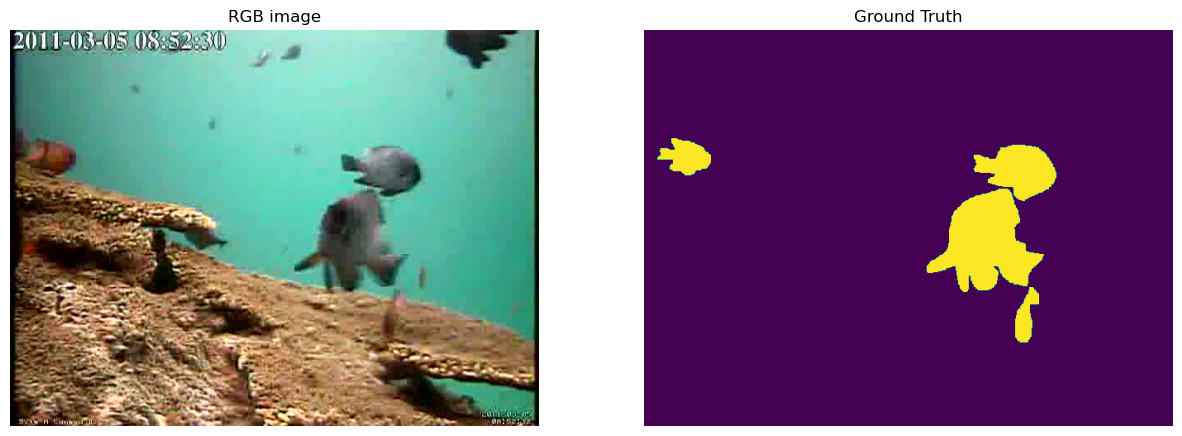

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread
import os

vid_path = 'video_data/Video/'
gt_path = 'video_data/GroundTruth/'

seq0 = [685, 705]
seq1 = [1173, 1191]

for no in range(*seq1):
    fid = os.path.join(vid_path, f'frame{no:04d}.jpg')
    rgb = imread(fid)

    fid = os.path.join(gt_path, f'{no}.png')
    supervision = imread(fid)

    plt.figure(figsize=(15, 15))
    
    plt.subplot(1, 2, 1)
    plt.title('RGB image')
    plt.imshow(rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Ground Truth')
    plt.imshow(supervision)
    plt.axis('off')

    plt.show() 

    break 



## Background image (Video segmentation)

When analyzing video sequences, we can use the *movement of the frame* to help our object segmentation. In this video, our goal is to segment the fish from the background. The background here is the part of the image that doesn't change from frame to frame: detecting the objects can therefore be done using **background subtraction**.

Implement the background subtraction algorithm:

1. Initialize background image: $B_{0} = I_{0}$ where $I_t$ is the image at time $t$ and $B$ is the estimated background. 
1. Update background: $B_{t} = \alpha B_{t-1} + (1-\alpha) I_t$
> What is the purpose of $\alpha$? How can you determine that your background estimation is "stable" and can be used?
1. Subtract background to detect foreground: $F_t = I_t - B_t$
1. Find a good post-processing to clean-up the foreground image. Label the individual objects (fish).
1. Using the supervised part of the sequence, estimate the detection error of your algorithm.
> *Hint: useful metrics for segmentation performance include per-pixel accuracy, precision, recall, or F1-score (DICE). These measures can also be made per-object, which is slightly more difficult to compute but in many applications a better indicator of the actual performance of the algorithm.*

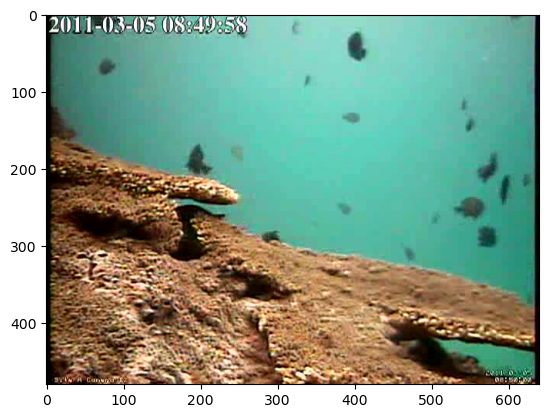

In [2]:
B = imread(os.path.join(vid_path, 'frame%04d.jpg' % 1))
plt.figure()
plt.imshow(B)
plt.show()

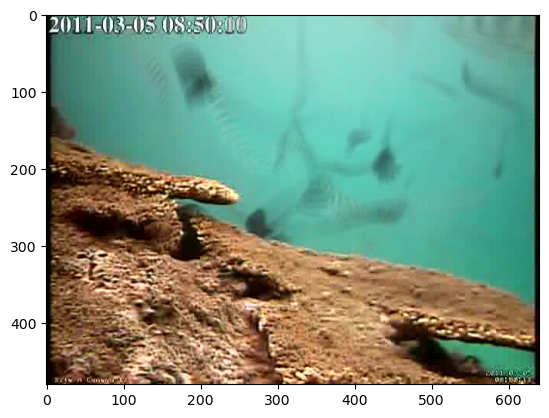

In [3]:
alpha = 0.90
for f in range(2, 101):
    I = imread(os.path.join(vid_path, 'frame%04d.jpg' % f))
    B = alpha * B + (1 - alpha) * I

plt.figure()
plt.imshow(B/255)
plt.show()

Ici, avec α=0.99, on garde 99% de l'ancien fond et on ajoute 1% de la nouvelle image.

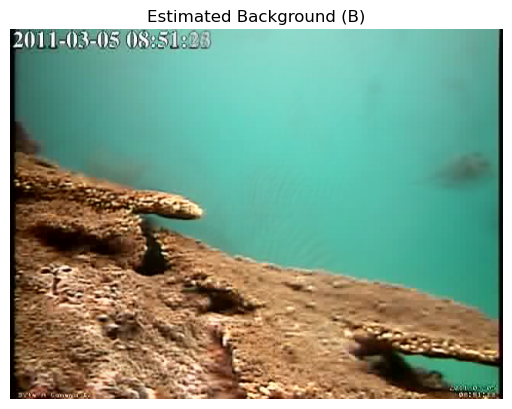

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import os

# Path to the video frames
vid_path = 'video_data/Video/'

# We will use frames starting from 685 for detection (so we stop before that)
seq0 = [685, 705]

# Step 1: Initialize the background B with the very first frame
B = imread(os.path.join(vid_path, 'frame0001.jpg'))

# Alpha controls how slowly the background is updated (close to 1 = slow change)
alpha = 0.99

# Step 2: Update the background using frames 2 to 684
# We stop before frame 685 to avoid including the detection frames in the background
for f in range(2, seq0[0]):  # range(2, 685)
    I = imread(os.path.join(vid_path, 'frame%04d.jpg'%f))
    B = alpha * B + (1 - alpha) * I  # weighted update: mostly old background + a bit of new frame

# Step 3: Show the estimated background
plt.figure()
plt.imshow(B / 255)  # normalize values to range [0, 1] for display
plt.title("Estimated Background (B)")
plt.axis('off')
plt.show()


This code computes the foreground mask by measuring how different each pixel in the current frame is from the estimated background .It uses the Euclidean distance between the RGB values of corresponding pixels.

0.14315397998060217 321.74127668767204


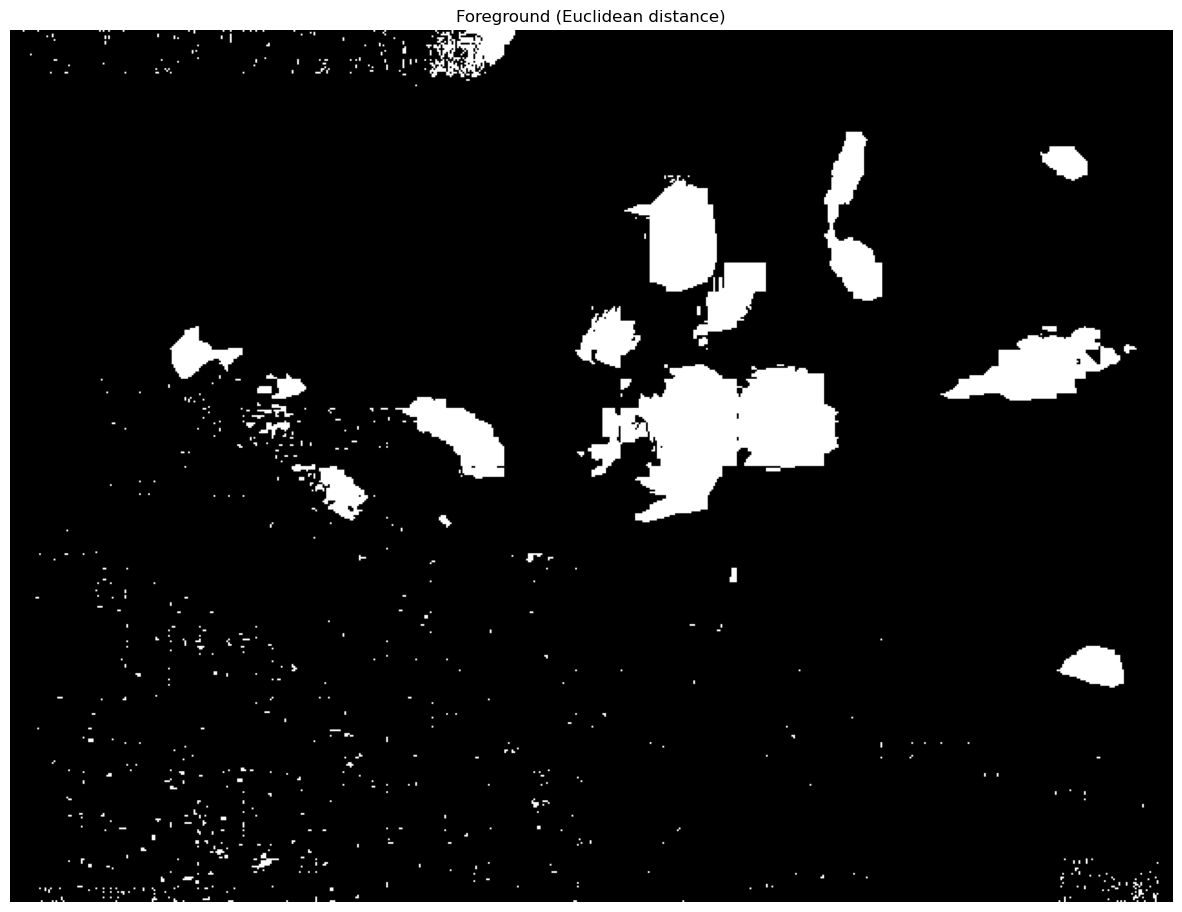

In [5]:
# Foreground detection using Euclidean distance between I and B (both RGB)
F = np.sqrt(((I - B) ** 2).sum(axis=2))

# Print min and max values for thresholding later
print(F.min(), F.max())

# Display the result
plt.figure(figsize=(15, 15))
plt.imshow(F > 50, cmap='gray')  # foreground differences as grayscale
plt.title("Foreground (Euclidean distance)")
plt.axis('off')
plt.show()


We loop over the test frames, compute the difference with the background, and compare it visually to the ground truth using contours.

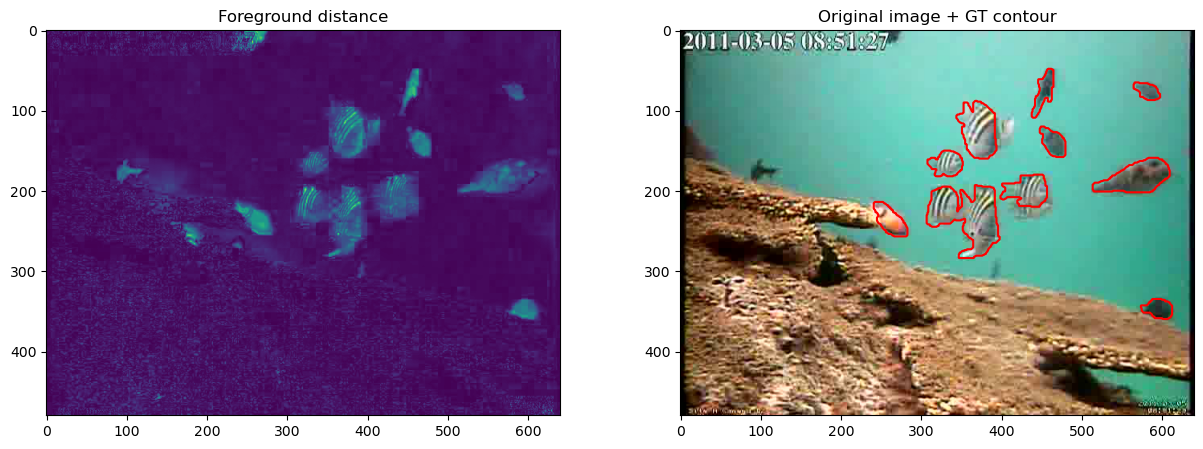

In [6]:
for f in range(*seq0):  # Loop over test frames (e.g. from 685 to 704)
    I = imread(os.path.join(vid_path, f'frame{f:04d}.jpg'))  # Load current RGB frame

    # Compute Euclidean distance between current frame and background
    F = np.sqrt(((I - B) ** 2).sum(axis=2))

    # Load ground truth mask and convert it to binary (True/False), S for supervision
    S = imread(os.path.join(gt_path, f'{f}.png')) > 0

    plt.figure(figsize=(15, 5))

    # Display the difference (foreground)
    plt.subplot(1, 2, 1)
    plt.imshow(F)
    plt.title('Foreground distance')

    # Display the original image with ground truth contours
    plt.subplot(1, 2, 2)
    plt.imshow(I)
    plt.contour(S, colors='r')  # overlay contour in red
    plt.title('Original image + GT contour')

    plt.show()
    break  # Remove this line to display all frames in the sequence


We compare our binary prediction mask to the ground truth using the F1-score (dice similary coef), which measures how well our segmentation matches the actual fish regions. A score of 1 is perfect, 0 is bad. Here, we get 0.76, which indicates decent detection.

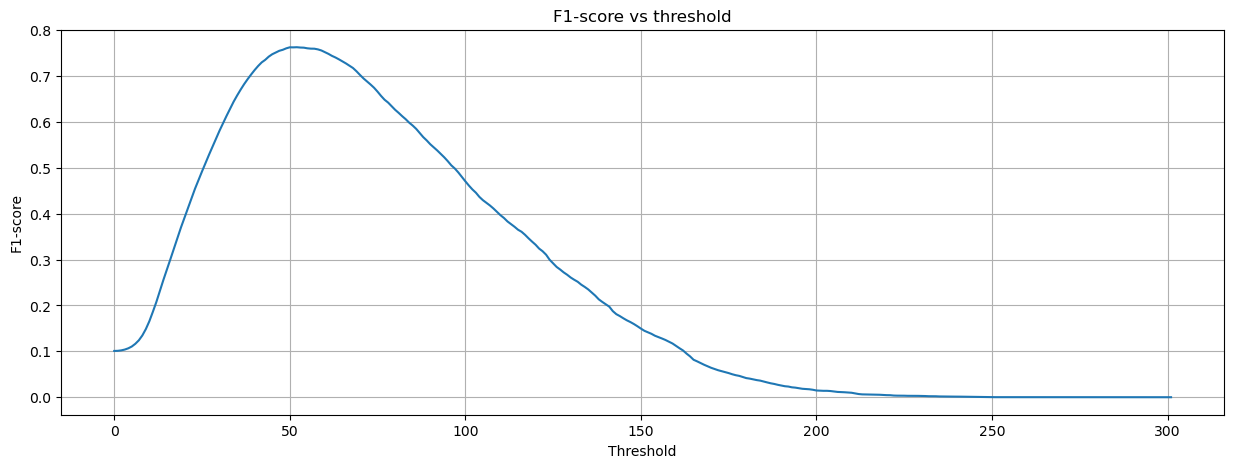

Best threshold: 52
Best F1-score: 0.7624518838212995


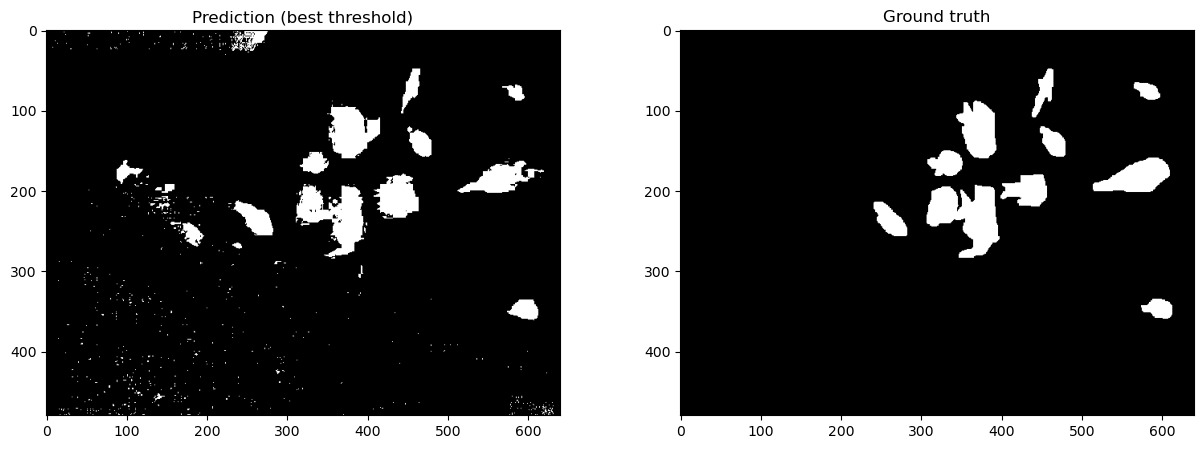

In [7]:
def F1(gt, pred):
    intersection = ((gt == 1) & (pred == 1)).sum()
    return 2 * intersection / (gt.sum() + pred.sum())

# Test many thresholds and store F1-scores
f1s = []
for t in range(int(F.max())):
    f1s.append(F1(S, F > t))

# Plot the curve
plt.figure(figsize=(15, 5))
plt.plot(f1s)
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs threshold")
plt.grid()
plt.show() 

# Best threshold based on maximum F1
best_t = np.argmax(f1s)
print("Best threshold:", best_t)
print("Best F1-score:", f1s[best_t])

# Generate prediction using best threshold
P = F > best_t

# Show results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(P, cmap='gray')
plt.title("Prediction (best threshold)")

plt.subplot(1, 2, 2)
plt.imshow(S, cmap='gray')
plt.title("Ground truth")
plt.show()



We can use morphological operation to remove little dots, ... so to clean everything.

0.7662076026288847


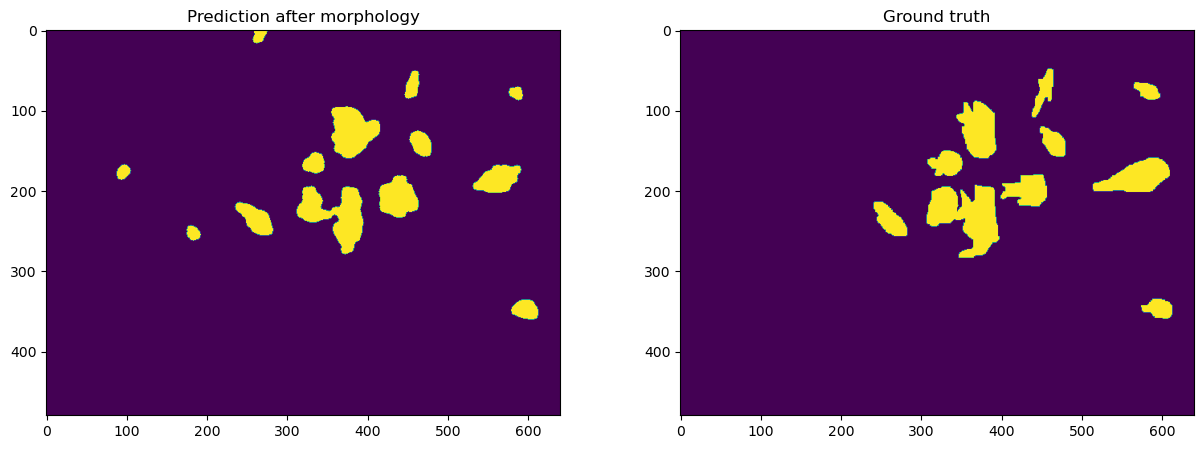

In [8]:
from skimage.morphology import opening, closing, disk

# Apply morphological opening then closing to clean the mask
P2 = opening(P, disk(5))
P2 = closing(P2, disk(3))

# Compute F1-score after morphological filtering
print(F1(S, P2))

# Display the cleaned mask and ground truth
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(P2)
plt.title("Prediction after morphology")

plt.subplot(1, 2, 2)
plt.imshow(S)
plt.title("Ground truth")

plt.show()



Note ! so way more cleaner but small improvement F1 score (why, because we remove small dots, and it is computed per pixel). donc pas bcp impact des mauvais pixels. Mais objectf est de trck les objets ! donc bien meilleure prediciton pcq pas des tonnes de plein de petits objets qu'il faudrait match et qui ne amtcherait à rien.

## Object tracking

1. Extract interesting features from the detected objects.
1. Suggest a method to recognise and track objects from one frame to the next frame.

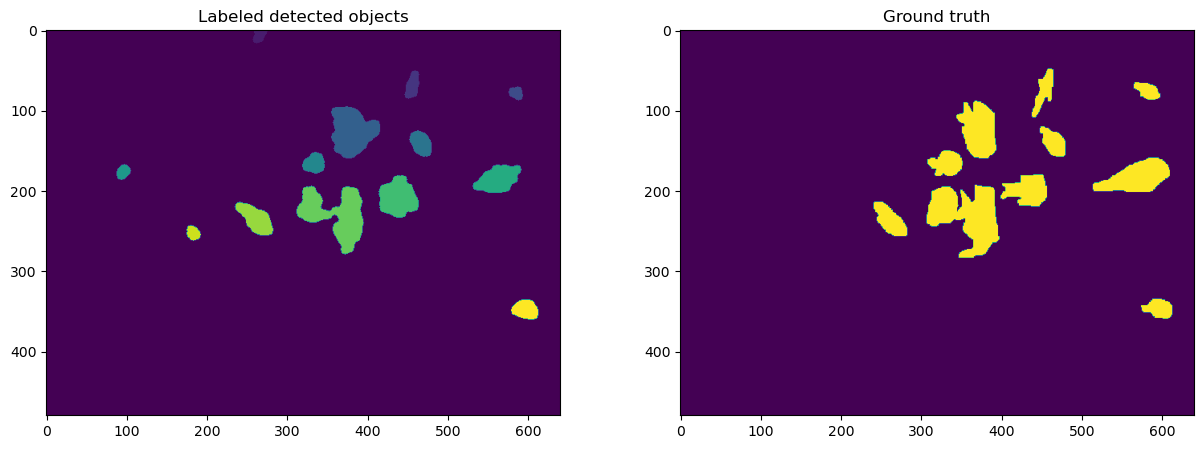

In [9]:
# We need to have separate objects using labels so that we can track them frame to frame.

# We start by the first frame
# Import the labeling function
from skimage.measure import label

# Apply connected component labeling to the cleaned mask
labels = label(P2)

# Display labeled objects and ground truth side by side
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(labels)
plt.title("Labeled detected objects")

plt.subplot(1, 2, 2)
plt.imshow(S)
plt.title("Ground truth")

plt.show()


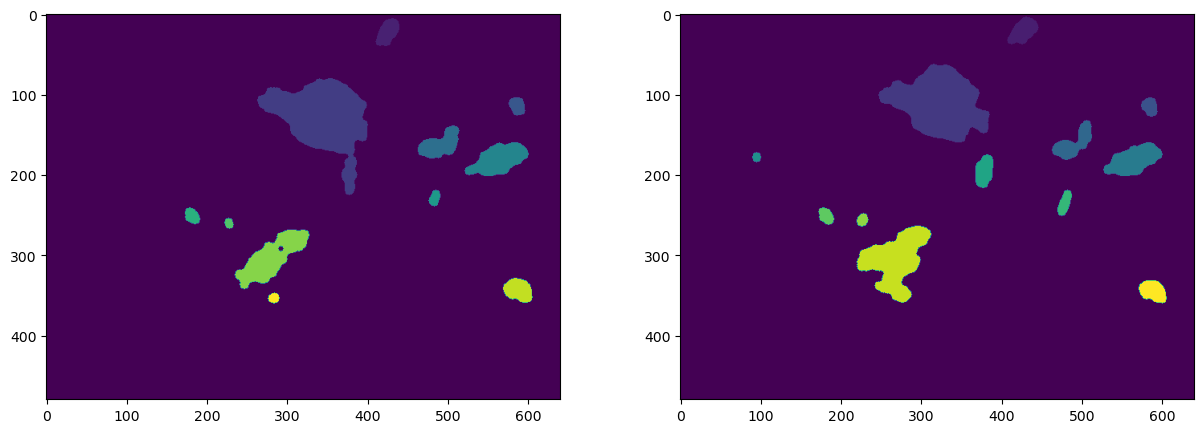

In [10]:
from skimage.morphology import opening, closing, disk
from skimage.measure import label

# Initial frame selection
start_frame = seq0[0] + 9

# Process first frame
I = imread(os.path.join(vid_path, 'frame%04d.jpg' % start_frame))
F = np.sqrt(((I - B) ** 2).sum(axis=2))
S = imread(os.path.join(gt_path, '%d.png' % start_frame)) > 0
P = opening(F > best_t, disk(5))
P = closing(P, disk(3))
labels = label(P)

# Process next frame
f = start_frame
I_next = imread(os.path.join(vid_path, 'frame%04d.jpg' % (f+1)))
F_next = np.sqrt(((I_next - B) ** 2).sum(axis=2))
S_next = imread(os.path.join(gt_path, '%d.png' % (f+1))) > 0

P_next = opening(F_next > best_t, disk(5))
P_next = closing(P_next, disk(3))
labels_next = label(P_next)

# Display both label images side by side
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(labels)

plt.subplot(1, 2, 2)
plt.imshow(labels_next)

plt.show()




For each detected object in frame *t*, we want to find the corresponding object in frame *t+1*.

To do this, we proceed as follows:

1. **Loop over all object labels** from the current frame (`labels`).
2. **For each object label:**
   - Check which pixels belong to that object:  
     `labels == lab`.
   - Look at which labels these same pixels have in the next frame:  
     `labels_next[labels == lab]`.
   - Extract the unique label values found in frame *t+1*:  
     `np.unique()`.
3. This gives us candidate matches for each object.
4. Finally, we visualize each object to verify the correspondence.

---

**Main idea:**

We match objects between frames based on their pixel overlap.  
If an object remains stable, most of its pixels will map to the same label in the next frame.


1 [0 1]


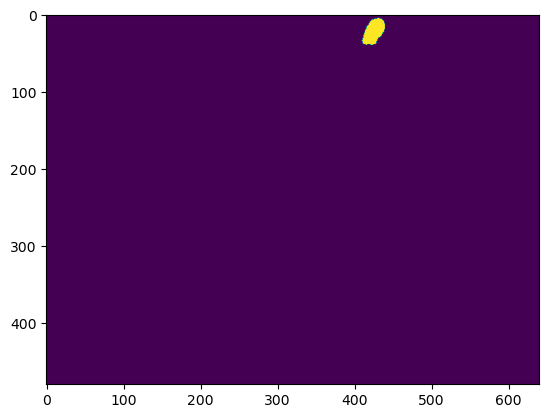

2 [0 2 7]


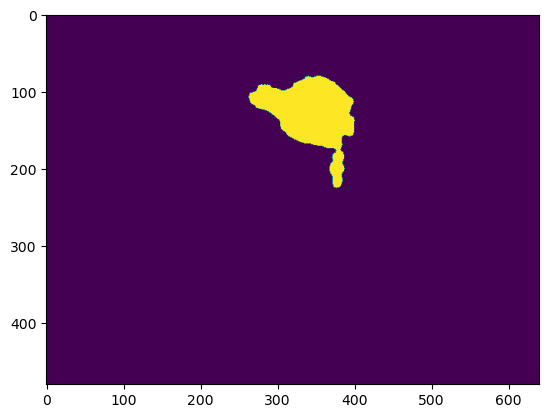

3 [0 3]


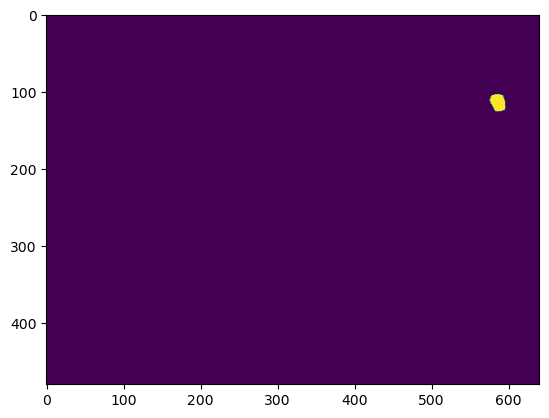

4 [0 4]


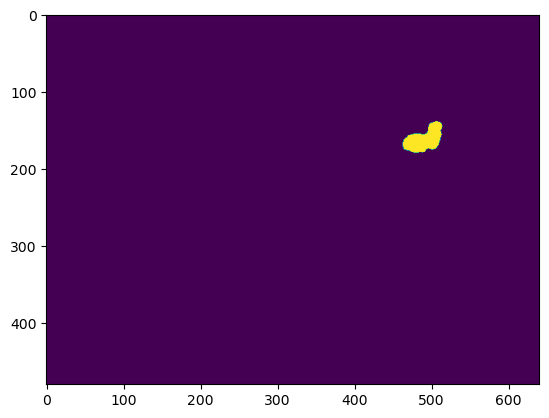

5 [0 5]


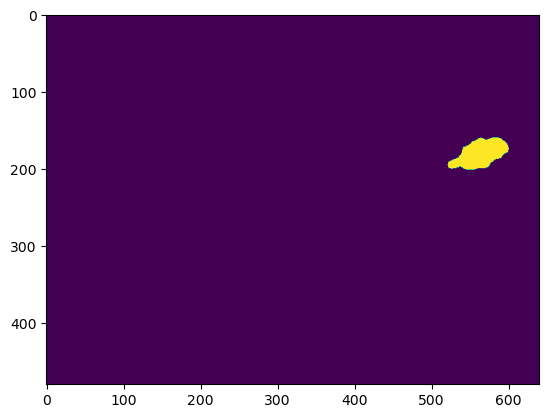

6 [0 8]


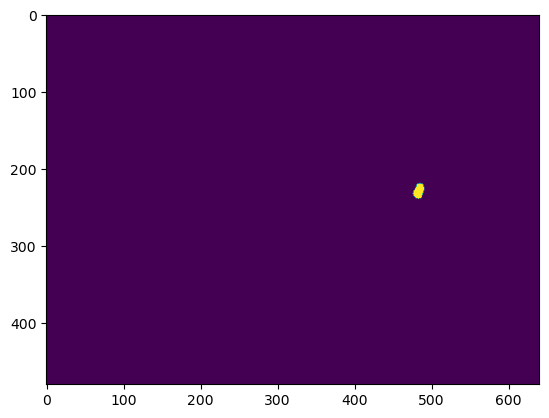

7 [9]


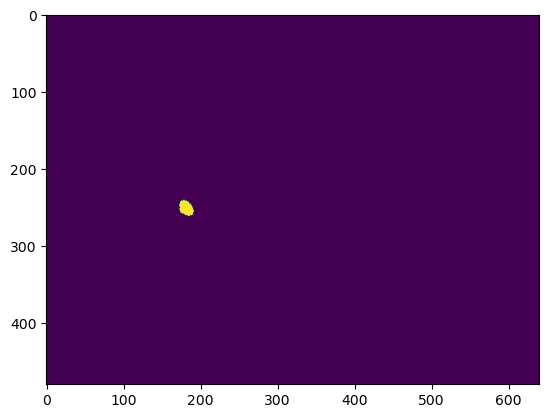

8 [ 0 10]


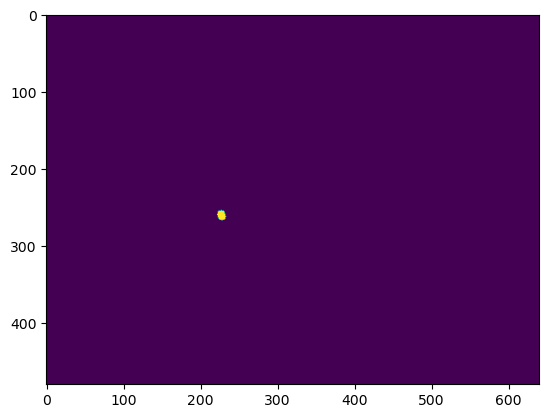

9 [ 0 11]


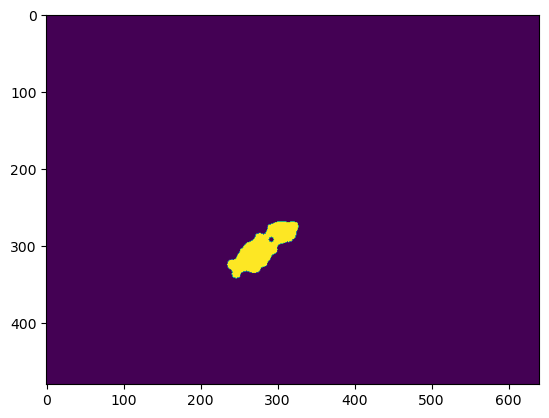

10 [ 0 12]


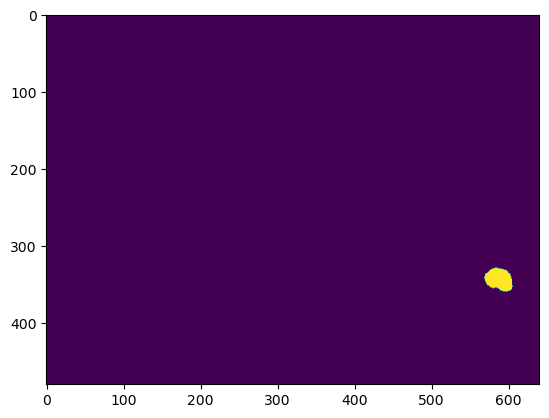

11 [ 0 11]


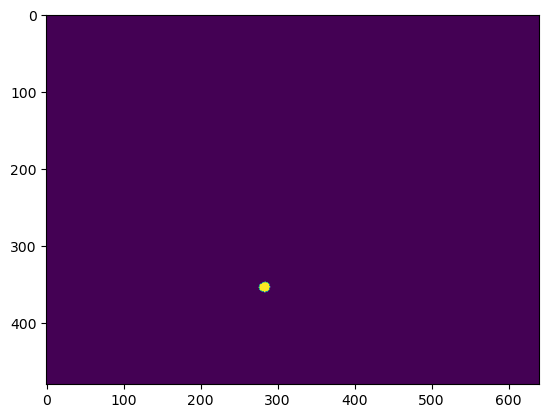

In [102]:
for lab in range(1, labels.max()+1):
    matching_objects = np.unique(labels_next[labels == lab])
    print(lab, matching_objects)
    
    plt.figure()
    plt.imshow(labels == lab)
    plt.show()